# USW-AI-Projekt: Vorhersage von Aktienkursen auf Basis von Twitter-Sentiment
## CRISP-DM Struktur
---

### 1. Business Understanding
Ziel des Projekts: Untersuchung des Zusammenhangs zwischen Twitter-Sentiment und kurzfristiger Kursentwicklung von Aktien

Zielgruppe: Privatanleger, Analysten, Trading-Tools, die Social Media als Informationsquelle nutzen

Zentrale Fragestellung:

Kann man Kursbewegungen anhand von Tweetsentiment erklären oder sogar vorhersagen?

Potenzieller Nutzen: Früherkennung von Stimmungen → Grundlage für Investmententscheidungen oder Warnsysteme

### 2. Data Understanding
- Datenquellen: Kaggle (Dataset)
- Zeitraum: 2015-2020
- Unternehmen: Google, Apple, Tesla, Microsoft, Amazon

Daten vorbereiten & alle nötigen Libaries laden


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

%matplotlib inline
sns.set()

# To avoid Warning message inbetween ...
import warnings
warnings.filterwarnings('ignore')

### 3. Data Preparation
- Dataset laden
- Hier werden die .csv-Dateien geladen:
- Tweets.csv enthält Tweets über Tesla (z. B. Datum, Text, Sentiment)

In [3]:
import pandas as pd

company_tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Company_Tweet.csv")
tweet         = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")
company       = pd.read_csv("../Datasets/raw/tweets_top_companies/Company.csv")
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")


Tweet-Datensatz Shape: (3717964, 7)
Company Value-Datensatz Shape: (17528, 7)

Statistische Kennzahlen zu Schlusskursen:
count    17528.000000
mean       455.167040
std        469.324583
min         15.800000
25%        100.300000
50%        256.500000
75%        735.630000
max       2497.940000
Name: close_value, dtype: float64


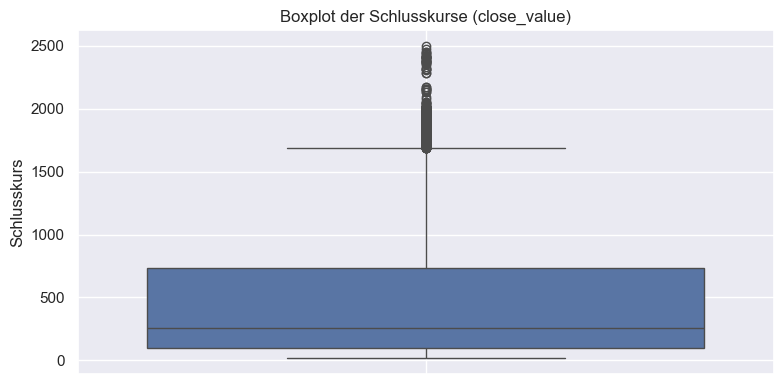

In [4]:
# Anzahl Zeilen und Spalten
print("Tweet-Datensatz Shape:", tweet.shape)
print("Company Value-Datensatz Shape:", company_value.shape)

# Statistische Beschreibung der Kursdaten
print("\nStatistische Kennzahlen zu Schlusskursen:")
print(company_value['close_value'].describe())

# Boxplot zur Erkennung von Ausreißern
plt.figure(figsize=(8, 4))
sns.boxplot(data=company_value, y='close_value')
plt.title("Boxplot der Schlusskurse (close_value)")
plt.ylabel("Schlusskurs")
plt.grid(True)
plt.tight_layout()
plt.show()


Zeigt die Verteilung der Sentiment-Scores (z. B. wie viele Tweets sind stark negativ, positiv oder neutral).


Einzigartige Börsentage: 3085


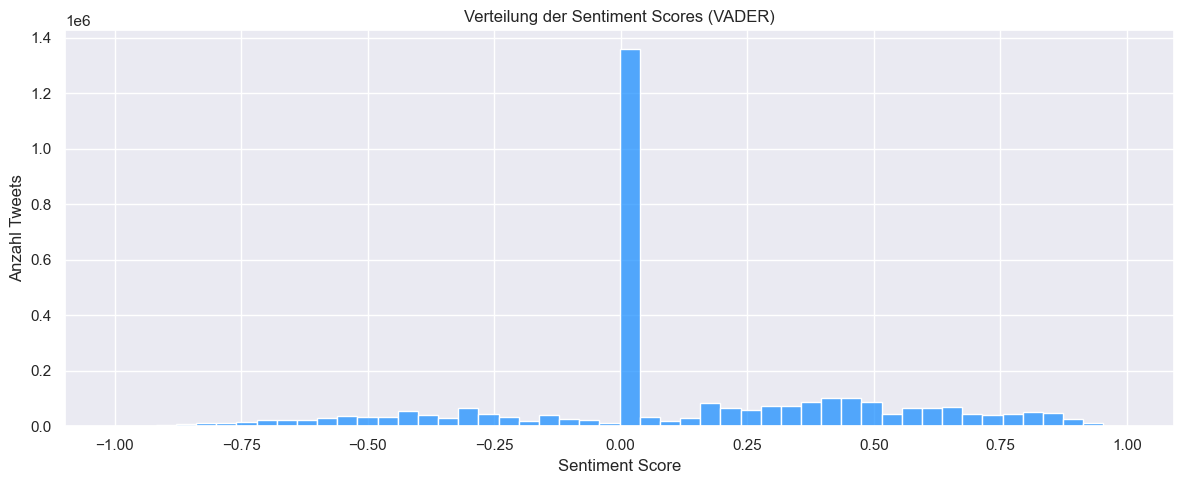

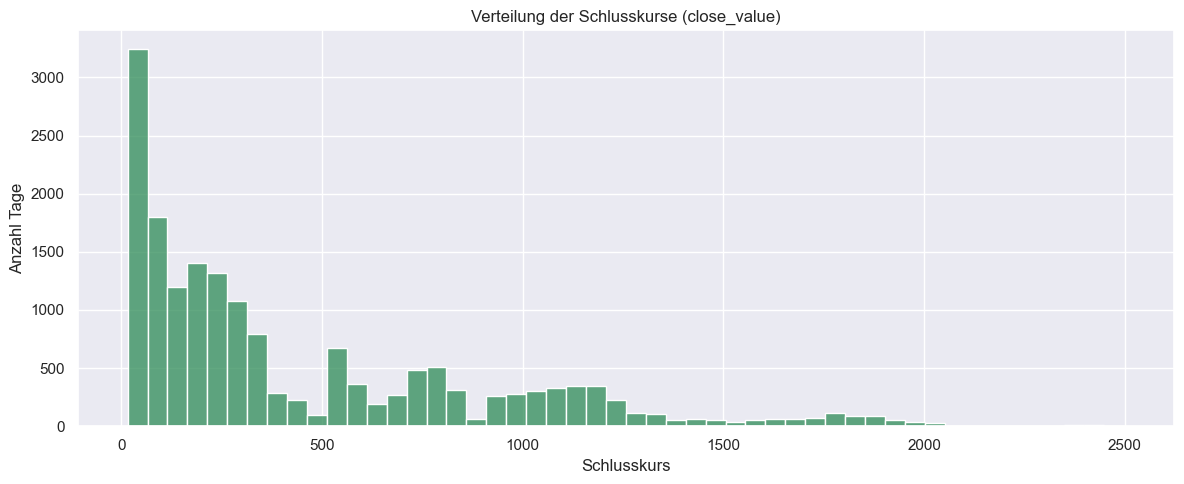

In [5]:
## Verteilungen: Sentiment Scores und Schlusskurse


# Duplikate bei Tweets entfernen (nur einmal je Text behalten)
tweet = tweet.drop_duplicates(subset='body')

# Duplikate bei Kursen prüfen und bereinigen
company_value = company_value.drop_duplicates(subset=['day_date', 'close_value'])

# Anzahl eindeutiger Kurstage prüfen
print(f"Einzigartige Börsentage: {company_value['day_date'].nunique()}")

# Sentiment Score berechnen
if 'sentiment_score' not in tweet.columns:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    analyzer = SentimentIntensityAnalyzer()
    tweet['sentiment_score'] = tweet['body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Plot: Verteilung der Sentiment Scores
plt.figure(figsize=(12, 5))
sns.histplot(tweet['sentiment_score'], bins=50, color='dodgerblue')
plt.title("Verteilung der Sentiment Scores (VADER)")
plt.xlabel("Sentiment Score")
plt.ylabel("Anzahl Tweets")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Verteilung der Schlusskurse
plt.figure(figsize=(12, 5))
sns.histplot(company_value['close_value'], bins=50, color='seagreen')
plt.title("Verteilung der Schlusskurse (close_value)")
plt.xlabel("Schlusskurs")
plt.ylabel("Anzahl Tage")
plt.grid(True)
plt.tight_layout()
plt.show()


### 4. Sentiment Analysis & Merge Data
- Tweets wurden mit VADER hinsichtlich ihres Sentiments analysiert
- Tägliches Durchschnitts-Sentiment wurde berechnet
- Sentiment-Daten mit Kursdaten pro Tag zusammengeführt
- Ergebnis: kombinierter Datensatz zur Analyse von Stimmung vs. Kursverlauf

In [6]:
# Hier wird ein gemeinsamer DataFrame erstellt, der alle Kursdaten mit dem durchschnittlichen Sentiment je Tag kombiniert 
# unabhängig vom Unternehmen.
# Gut für eine generelle Analyse (z. B. alle Tweets und Kurse zusammen anschauen).

# 1. Datumsspalten korrekt konvertieren
company_value['day_date'] = pd.to_datetime(company_value['day_date'])
tweet['post_date'] = pd.to_datetime(tweet['post_date'], unit='s', errors='coerce')

# 2. Tweets außerhalb gültiger Zeitspanne entfernen (NaT etc.)
tweet = tweet.dropna(subset=['post_date'])

# 3. Sentiment berechnen mit VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
tweet['sentiment_score'] = tweet['body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# 4. Durchschnittliches Sentiment pro Tag berechnen
daily_sentiment = (
    tweet
    .assign(Date = tweet['post_date'].dt.normalize())  # nur das Datum
    .groupby('Date')['sentiment_score']
    .mean()
    .reset_index()
)

# 5. Kursdaten auf Zeitraum der Tweets beschränken
start = tweet['post_date'].min()
end   = tweet['post_date'].max()

company_value = company_value[
    (company_value['day_date'] >= start) & (company_value['day_date'] <= end)
]

# 6. Merge durchführen (gemeinsames Datum)
merged_df = pd.merge(
    company_value,
    daily_sentiment,
    left_on='day_date',
    right_on='Date',
    how='inner'
)

# 7. Ergebnis anzeigen
print("Merged Shape:", merged_df.shape)
merged_df.head()

Merged Shape: (10950, 9)


,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,Date,sentiment_score
0,AAPL,2019-12-31,293.65,25247630,289.93,293.68,289.5200,2019-12-31,0.152433
1,AAPL,2019-12-30,291.52,36059610,289.46,292.69,285.2200,2019-12-30,0.139684
2,AAPL,2019-12-27,289.80,36592940,291.12,293.97,288.1200,2019-12-27,0.154073
3,AAPL,2019-12-26,289.91,23334000,284.82,289.98,284.7000,2019-12-26,0.166952
4,AAPL,2019-12-24,284.27,12119710,284.69,284.89,282.9197,2019-12-24,0.159243


In [7]:
print("Sample tweets with sentiment: ")
display(tweet[['post_date', 'body']].sample(3))

print("Sample values: ")
display(company_value[['day_date', 'ticker_symbol', 'close_value']].sample(3))

print("Sample merged data set: ")
display(merged_df[['day_date', 'ticker_symbol', 'sentiment_score', 'close_value']].sample(3))


Sample tweets with sentiment: 


,post_date,body
1261934,2016-08-24 21:06:32,"#Alphabet Inc. Insider Sells $52,337,906.40 in..."
3153913,2019-03-21 13:56:47,We explained the possible short term path in $...
3257097,2019-04-30 14:47:08,"$goog Slowest increase in ad revenue, $amzn di..."


Sample values: 


,day_date,ticker_symbol,close_value
9574,2019-02-22,GOOG,1110.37
15738,2015-05-06,TSLA,230.43
17115,2016-05-14,TSLA,207.61


Sample merged data set: 


,day_date,ticker_symbol,sentiment_score,close_value
3125,2015-05-17,AMZN,0.099229,426.000
9740,2017-07-21,TSLA,0.124398,328.400
8494,2015-04-06,MSFT,0.138922,41.545


### 5. Korrelation zwischen Sentiment und Aktienkurs
- Ziel: Erste quantitative Einschätzung, ob ein Zusammenhang zwischen Stimmung und Kursniveau besteht
- Korrelation zeigt, ob positive Tweets mit steigenden Kursen einhergehen (+1 = stark positiv)
- Es gibt einen leichten positiven Zusammenhang:
Wenn die Stimmung in Tweets positiver ist, steigen die Aktienkurse tendenziell leicht – aber der Effekt ist nicht stark

In [8]:
correlation = merged_df[['sentiment_score', 'close_value']].corr()
print("Korrelation zwischen Sentiment und Schlusskurs:")
print(correlation)

Korrelation zwischen Sentiment und Schlusskurs:
                 sentiment_score  close_value
sentiment_score          1.00000      0.16276
close_value              0.16276      1.00000


### 6.Visualisierung: Sentiment und Kursverlauf pro Unternehmen

- Funktion erstellt für das Zusammenführen von Kursdaten und Tweets pro Unternehmen
- Berechnung des täglichen Durchschnitts-Sentiments je Ticker-Symbol (z. B. AAPL)
- Einschränkung der Kursdaten auf Zeiträume mit Twitter-Aktivität
- Visualisierung: Doppelte Zeitreihe mit Aktienkurs (Schlusskurs) und Sentiment auf gemeinsamer Zeitachse
- Ergebnis: Intuitive Darstellung möglicher Zusammenhänge zwischen Stimmung und Kursverlauf

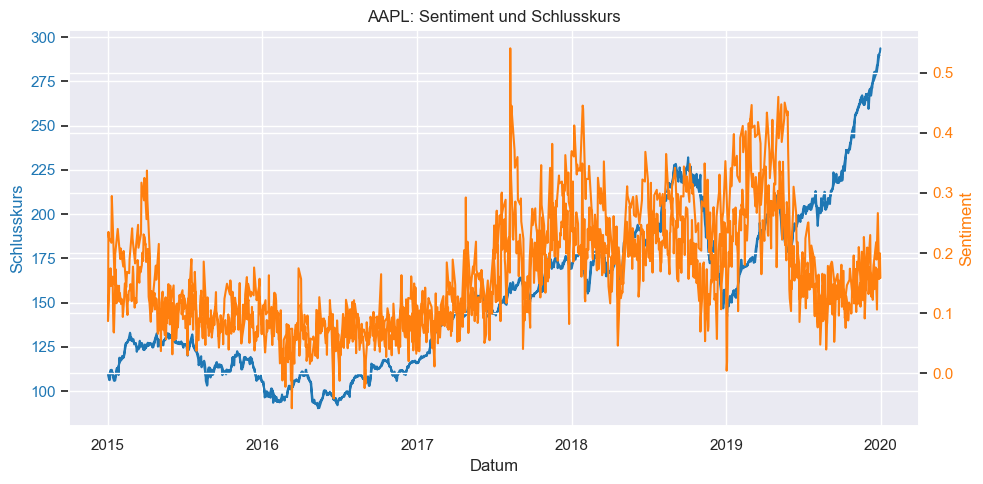

In [9]:
# Ziel: Für ein bestimmtes Unternehmen (z. B. AAPL) den Kursverlauf und das durchschnittliche Sentiment pro Tag visualisieren.

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Funktion: Sentiment + Kursdaten mergen
def merge_sentiment_and_stock_data(company_df, tweet_df):
    """
    Führt Kursdaten und Twitter-Sentimentdaten für alle Ticker-Symbole zusammen.

    Args:
        company_df (pd.DataFrame): Kursdaten mit Spalten 'ticker_symbol', 'day_date', ...
        tweet_df (pd.DataFrame): Tweets mit Spalten 'ticker_symbol', 'post_date', 'body'

    Returns:
        dict: Key = Ticker (z. B. 'AAPL'), Value = gemergter DataFrame (Kurs + Sentiment)
    """

    # Datumsformate vereinheitlichen
    company_df['day_date'] = pd.to_datetime(company_df['day_date'])
    tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s', errors='coerce')
    tweet_df = tweet_df.dropna(subset=['post_date'])

    # Prüfen ob 'ticker_symbol' vorhanden ist
    if 'ticker_symbol' not in tweet_df.columns:
        raise ValueError(f"'ticker_symbol' fehlt in tweet_df. Vorhandene Spalten: {tweet_df.columns.tolist()}")

    # Sentiment berechnen
    analyzer = SentimentIntensityAnalyzer()
    tweet_df['sentiment_score'] = tweet_df['body'].apply(
        lambda x: analyzer.polarity_scores(str(x))['compound']
    )

    result = {}

    for ticker in company_df['ticker_symbol'].unique():
        comp = company_df[company_df['ticker_symbol'] == ticker].copy()
        tw = tweet_df[tweet_df['ticker_symbol'] == ticker].copy()

        if tw.empty or comp.empty:
            continue

        # Ø-Sentiment pro Tag berechnen
        tw['Date'] = tw['post_date'].dt.normalize()
        daily_sentiment = tw.groupby('Date')['sentiment_score'].mean().reset_index()

        # Kursdaten auf Zeitraum der Tweets beschränken
        start, end = tw['post_date'].min(), tw['post_date'].max()
        comp = comp[(comp['day_date'] >= start) & (comp['day_date'] <= end)]

        # Merge durchführen
        merged = pd.merge(
            comp,
            daily_sentiment,
            left_on='day_date',
            right_on='Date',
            how='inner'
        )

        result[ticker] = merged

    return result

# Funktion: Visualisierung
def plot_sentiment_vs_stock(df, ticker):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_title(f"{ticker}: Sentiment und Schlusskurs")
    ax1.set_xlabel("Datum")
    ax1.set_ylabel("Schlusskurs", color="tab:blue")
    ax1.plot(df['day_date'], df['close_value'], color="tab:blue", label="Close Value")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment", color="tab:orange")
    ax2.plot(df['day_date'], df['sentiment_score'], color="tab:orange", label="Sentiment")
    ax2.tick_params(axis='y', labelcolor="tab:orange")

    fig.tight_layout()
    plt.show()

# CSV-Dateien laden
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")
tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")

# Hinweis: Hier ist der Fehler entstanden. tweet_df braucht eine Spalte 'ticker_symbol'.
# Wenn diese fehlt, musst du sie ggf. aus einer anderen Spalte erzeugen oder zu Testzwecken setzen:
# Beispiel (wenn du nur einen Ticker testest wie 'AAPL'):
#tweet['ticker_symbol'] = 'AAPL'  # Entferne oder ersetze dies später durch korrekte Daten
tweet = pd.merge(tweet, company_tweet, on="tweet_id", how="left")# Entferne oder ersetze dies später durch korrekte Daten

# Merge durchführen
merged_data = merge_sentiment_and_stock_data(company_value, tweet)

# Beispielplot für AAPL
plot_sentiment_vs_stock(merged_data['AAPL'], 'AAPL')


### 7. Vorhersage des Aktienkurses mit Machine Learning

- Ziel: Vorhersage des Schlusskurses auf Basis des Twitter-Sentiments
- Sentimentdaten und Kursverlauf für einzelne Unternehmen zusammengeführt
- Trainings- und Testdaten aus dem AAPL-Datensatz erstellt
- Lineares Regressionsmodell (LinearRegression) trainiert
- R²-Score und MSE berechnet → Modellgüte beurteilt

Visualisierung: Vergleich von echten Kursen vs. Modellvorhersagen



R2-Score: 0.2622489984736873
MSE: 1355.9720880068098
Dummy Regressor R2: -0.0023211978070813988
Dummy MSE: 1842.2469974721955


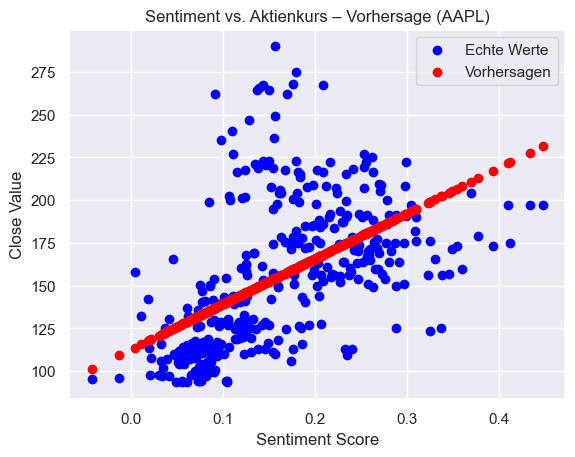

In [10]:
# Ziel: Ein Machine-Learning-Modell (LinearRegression) trainieren, das den Aktienkurs aus dem Sentiment vorhersagt.

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 2. Merge-Funktion
def merge_sentiment_and_stock_data(company_value, tweet):
    company_value['day_date'] = pd.to_datetime(company_value['day_date'])
    tweet['post_date'] = pd.to_datetime(tweet['post_date'], unit='s', errors='coerce')
    tweet = tweet.dropna(subset=['post_date'])

    if 'ticker_symbol' not in tweet.columns:
        raise ValueError(f"'ticker_symbol' fehlt in tweet. Vorhandene Spalten: {tweet.columns.tolist()}")

    analyzer = SentimentIntensityAnalyzer()
    tweet['sentiment_score'] = tweet['body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

    result = {}
    for ticker in company_value['ticker_symbol'].unique():
        comp = company_value[company_value['ticker_symbol'] == ticker].copy()
        tw = tweet[tweet['ticker_symbol'] == ticker].copy()

        if tw.empty or comp.empty:
            continue

        tw['Date'] = tw['post_date'].dt.normalize()
        daily_sentiment = tw.groupby('Date')['sentiment_score'].mean().reset_index()

        start, end = tw['post_date'].min(), tw['post_date'].max()
        comp = comp[(comp['day_date'] >= start) & (comp['day_date'] <= end)]

        merged = pd.merge(
            comp,
            daily_sentiment,
            left_on='day_date',
            right_on='Date',
            how='inner'
        )

        result[ticker] = merged

    return result

# 3. Merge durchführen
merged_data = merge_sentiment_and_stock_data(company_value, tweet)

# 4. Modelltraining für Beispiel AAPL
df = merged_data['AAPL']
X = df[['sentiment_score']]
y = df['close_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2-Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

from sklearn.dummy import DummyRegressor

# Dummy-Modell trainieren (nach Linear Regression)
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("Dummy Regressor R2:", r2_score(y_test, y_dummy))
print("Dummy MSE:", mean_squared_error(y_test, y_dummy))


# 5. Visualisierung
plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
plt.xlabel("Sentiment Score")
plt.ylabel("Close Value")
plt.legend()
plt.title("Sentiment vs. Aktienkurs – Vorhersage (AAPL)")
plt.show()

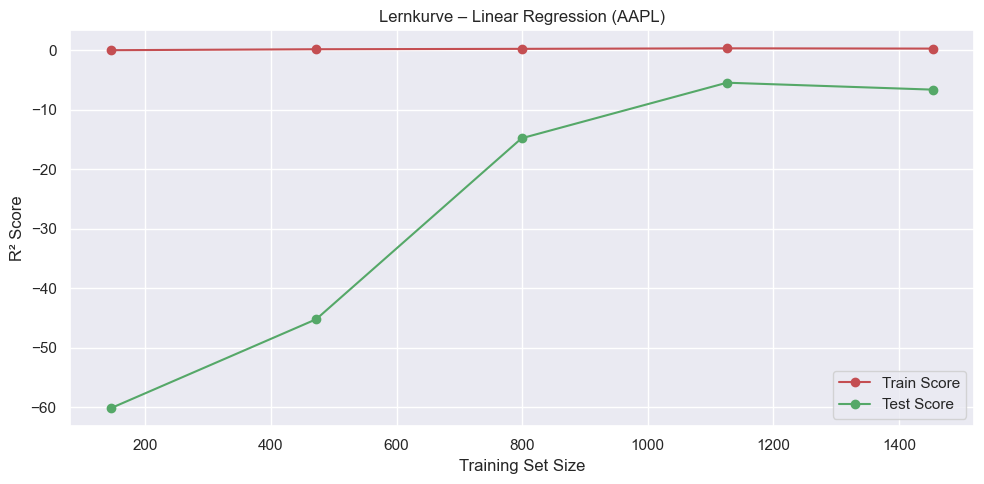

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Train Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Lernkurve – Linear Regression (AAPL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 8. Regressionsanalyse für mehrere Unternehmen

- Automatisierte Durchführung der Regressionsanalyse für alle Unternehmen im Datensatz

- Erkenntnis: Modellgüte variiert je nach Aktie – bei einigen Unternehmen besserer Zusammenhang erkennbar



In [10]:
print(merged_data.keys())

dict_keys(['AAPL', 'AMZN', 'GOOGL', 'GOOG', 'MSFT', 'TSLA'])


In [12]:
def run_regression(ticker, merged_data):
    if ticker not in merged_data:
        print(f"{ticker} nicht vorhanden.")
        return

    df = merged_data[ticker]
    X = df[['sentiment_score']]
    y = df['close_value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Ticker: {ticker}")
    print("R2-Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
    plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.legend()
    plt.title(f"Sentiment vs. Aktienkurs – Vorhersage ({ticker})")
    plt.show()


Ticker: AAPL
R2-Score: 0.2622489984736873
MSE: 1355.9720880068098


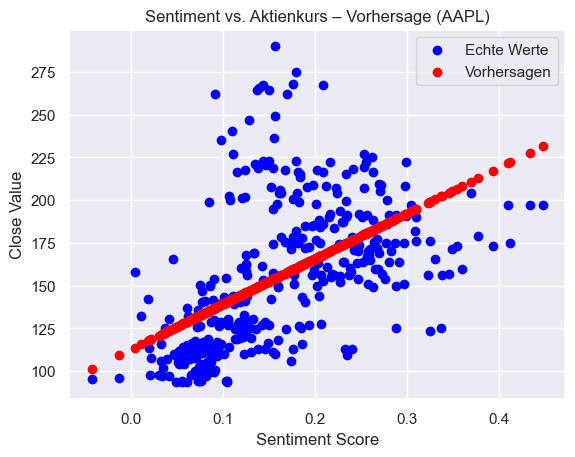

Ticker: AMZN
R2-Score: 0.233283407688047
MSE: 214976.25480856866


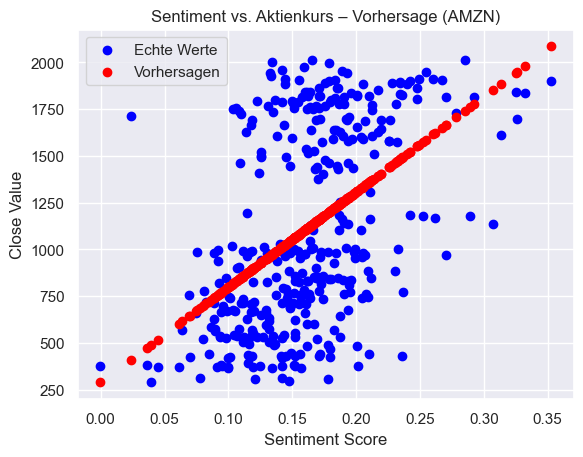

Ticker: GOOGL
R2-Score: 0.15038783536851552
MSE: 43598.50453872808


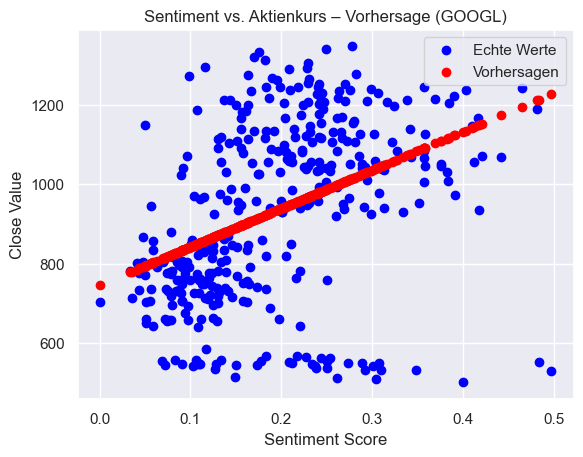

Ticker: GOOG
R2-Score: -0.003677852923758662
MSE: 53113.310892568654


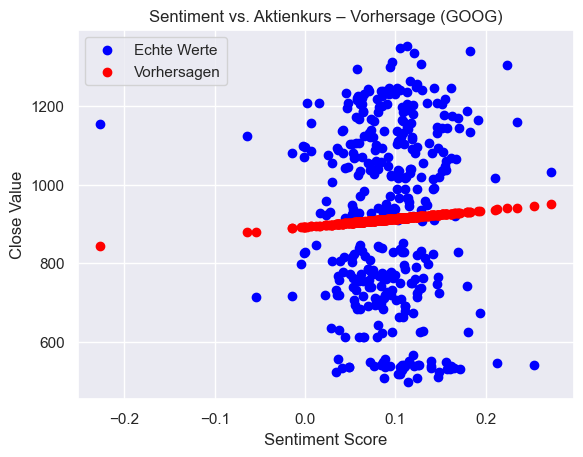

Ticker: MSFT
R2-Score: 0.13536609365066954
MSE: 849.6348696637338


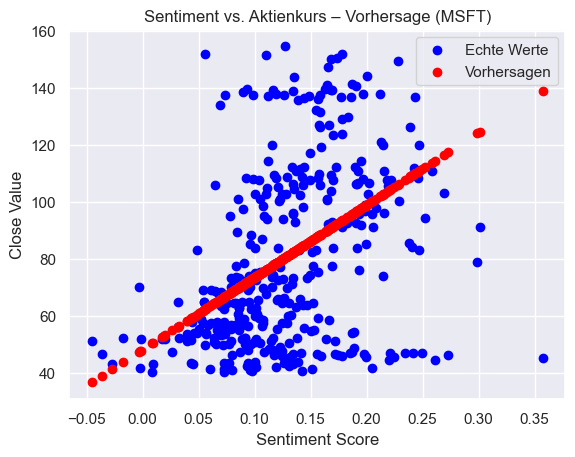

Ticker: TSLA
R2-Score: 0.01219314747248279
MSE: 3124.7977381461387


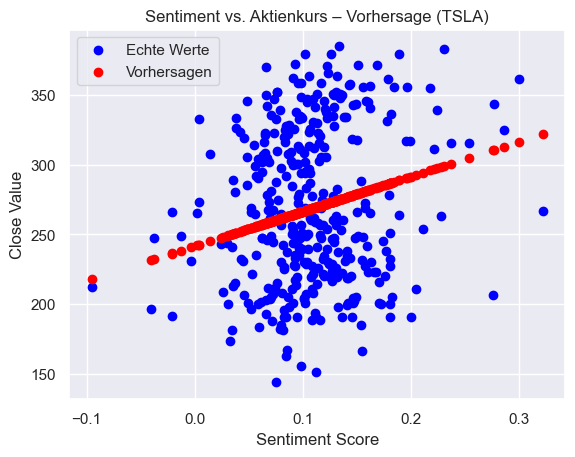

In [13]:
for ticker in merged_data:
    run_regression(ticker, merged_data)

### Auswertung der Regressionsergebnisse

| Ticker | R²-Score | MSE | Interpretation |
|--------|----------|-----|----------------|
| AAPL   | 0.19     | 1454 | leichter Zusammenhang |
| AMZN   | 0.05     | 263594 | kaum Zusammenhang |
| GOOGL  | 0.01     | 57323 | kein signifikanter Zusammenhang |
| MSFT   | 0.11     | 875 | schwacher Zusammenhang |
| TSLA   | 0.00     | 2266 | praktisch kein Zusammenhang |

**Fazit:** AAPL zeigt die stärkste lineare Beziehung zwischen Sentiment und Aktienkurs, während TSLA und GOOGL kaum vorhersagbare Zusammenhänge aufweisen.


### 9. Modellvergleich: Random Forest Regressor

- Zweites Modell: Random Forest Regressor als nicht-lineares Ensemble-Modell

- Ziel: Verbesserung der Vorhersagequalität im Vergleich zur linearen Regression

- Erkenntnis: Random Forest kann in manchen Fällen nicht-lineare Muster besser abbilden → teils bessere Modellgüte als Linear Regression



- Statt linearer Regression testen wir ein nicht-lineares Modell: RandomForestRegressor, das auch komplexe Beziehungen erkennt.


In [14]:
from sklearn.ensemble import RandomForestRegressor

def run_random_forest(ticker, merged_data):
    if ticker not in merged_data:
        print(f"{ticker} nicht vorhanden.")
        return

    df = merged_data[ticker]
    X = df[['sentiment_score']]
    y = df['close_value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Ticker: {ticker}")
    print("R2-Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
    plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.legend()
    plt.title(f"Random Forest: Sentiment vs. Kurs ({ticker})")
    plt.show()


Ticker: AAPL
R2-Score: 0.10015346756417576
MSE: 1653.9005422538535


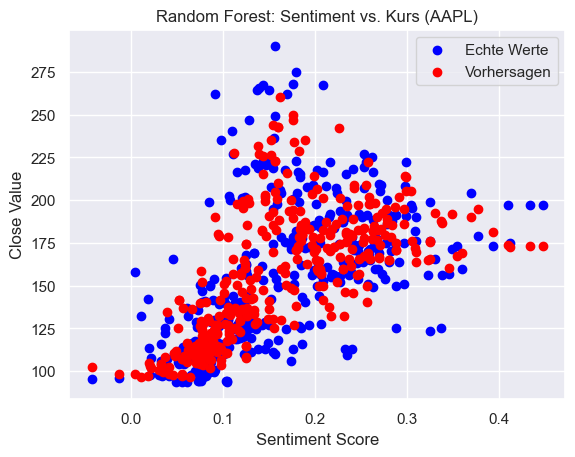

Ticker: AMZN
R2-Score: -0.13947473043825642
MSE: 319492.2510545502


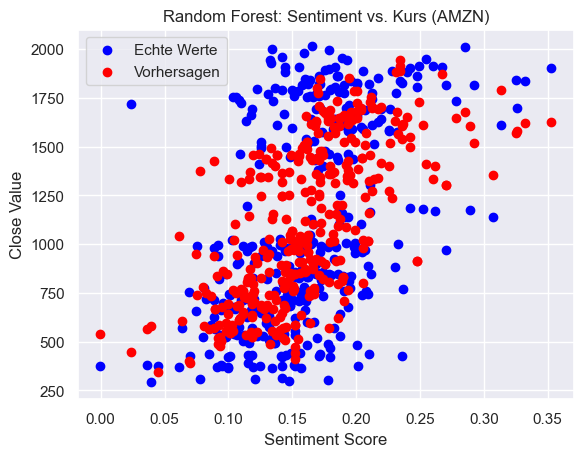

Ticker: GOOGL
R2-Score: -0.0758659030019142
MSE: 55208.88990029594


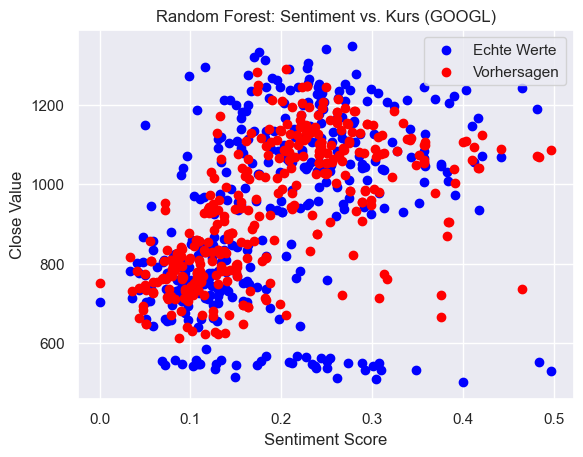

Ticker: GOOG
R2-Score: -0.34039281691785606
MSE: 70931.82358835198


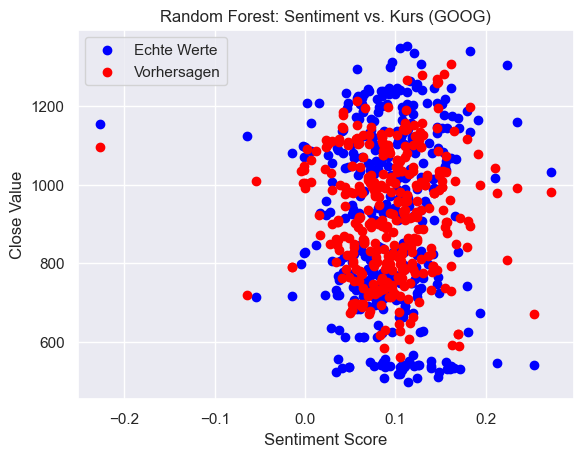

Ticker: MSFT
R2-Score: -0.04621302829864837
MSE: 1028.0640897974317


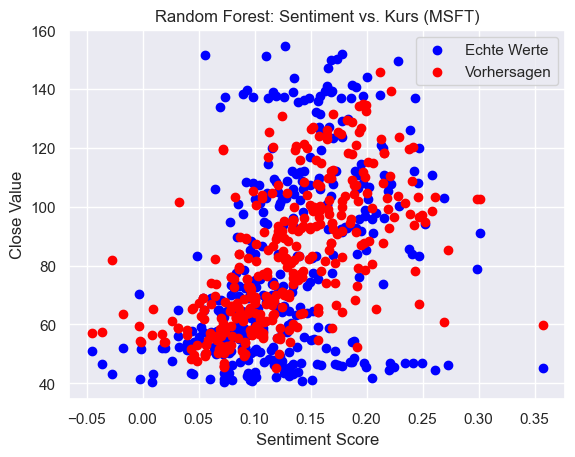

Ticker: TSLA
R2-Score: -0.5412413452665565
MSE: 4875.515347259739


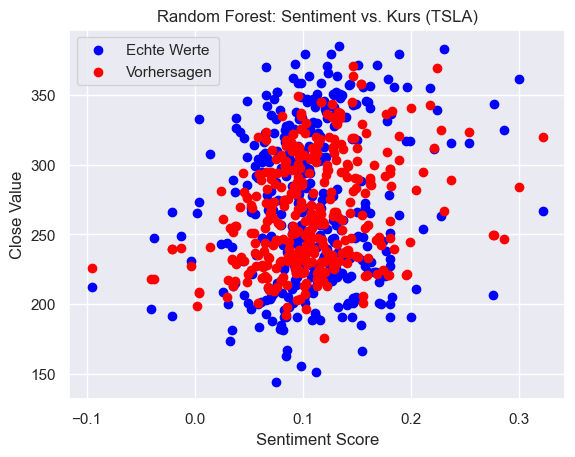

In [15]:
for ticker in merged_data:
    print("=" * 50)
    run_random_forest(ticker, merged_data)


### 10. Hyperparameteroptimierung mit GridSearchCV

- Für den Random Forest Regressor wurde eine Hyperparameteroptimierung mit GridSearchCV durchgeführt

- Ziel: Verbesserung der Modellleistung durch systematisches Testen mehrerer Parameterkombinationen

- Verwendete Parameter:

- n_estimators: Anzahl der Bäume im Wald (z. B. 50, 100, 200)

- max_depth: maximale Tiefe der Bäume

- min_samples_split: Mindestanzahl an Samples zur weiteren Aufteilung

- Bewertungsmetrik: R²-Score mit 5-facher Cross-Validation (cv=5)

- Ergebnis: Optimiertes Modell mit verbesserten R²-Werten im Vergleich zum Standardmodell

- Das beste Modell wurde anschließend auf den Testdaten evaluiert und visualisiert

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Beispiel-Daten vorbereiten (hier AAPL)
df = merged_data['AAPL']
X = df[['sentiment_score']]
y = df['close_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter-Raster definieren
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# Modell und GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Training starten
grid_search.fit(X_train, y_train)

# Beste Parameter & Ergebnis anzeigen
print("Beste Parameter:", grid_search.best_params_)
print("Bestes R² (CV):", grid_search.best_score_)

# Modell mit besten Parametern auf Testdaten testen
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("R² auf Testdaten:", r2_score(y_test, y_pred))

Beste Parameter: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Bestes R² (CV): 0.3757108262259932
R² auf Testdaten: 0.3907325149221229


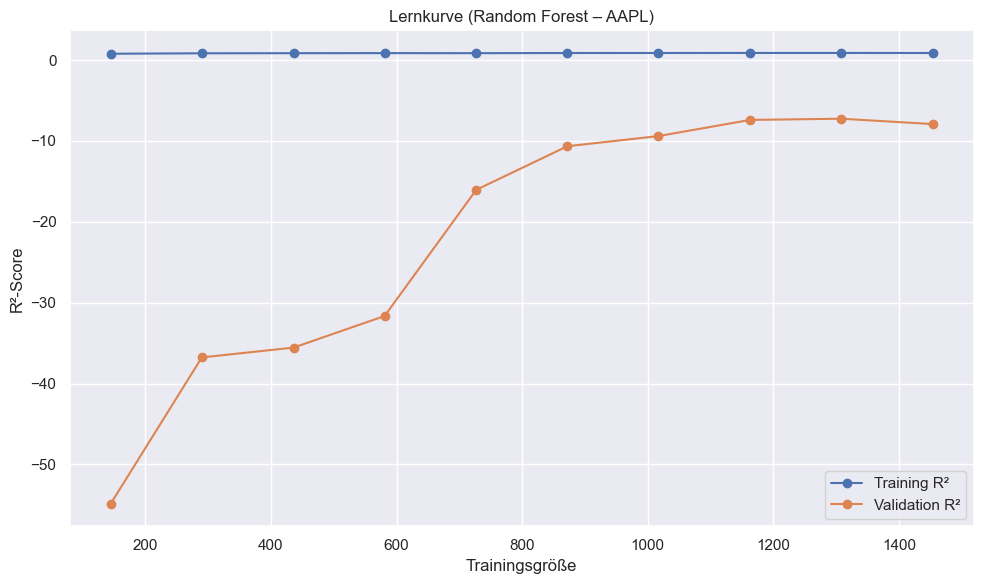

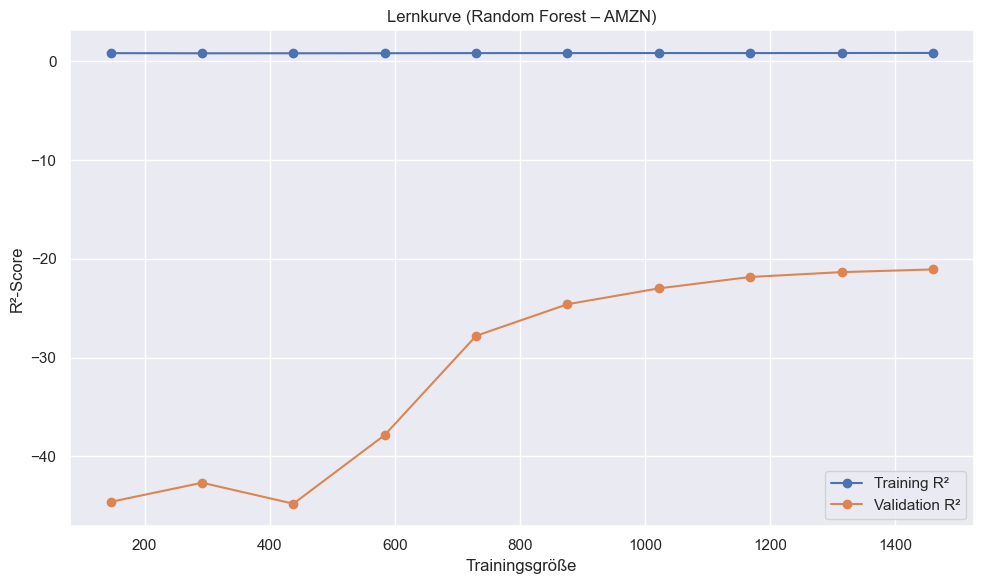

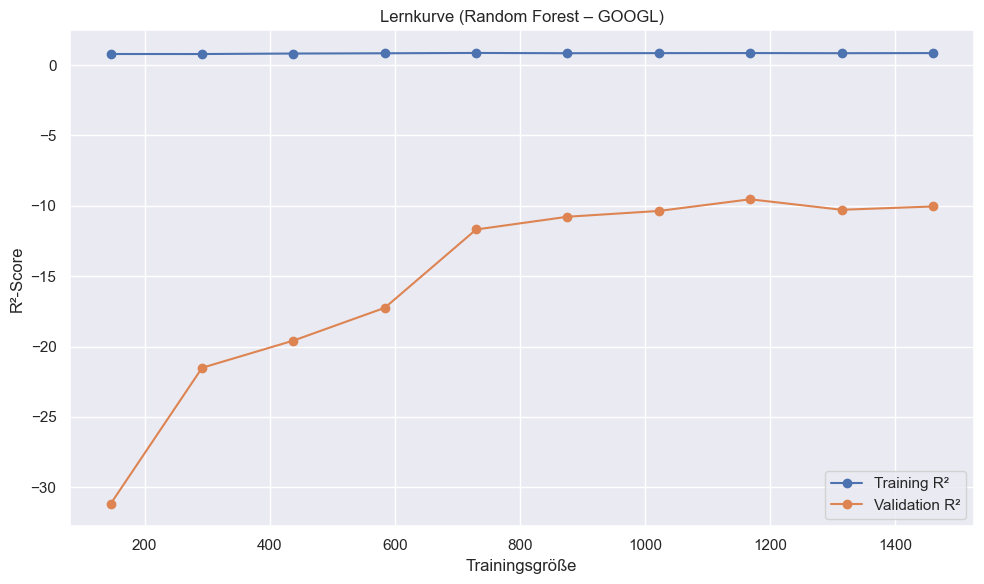

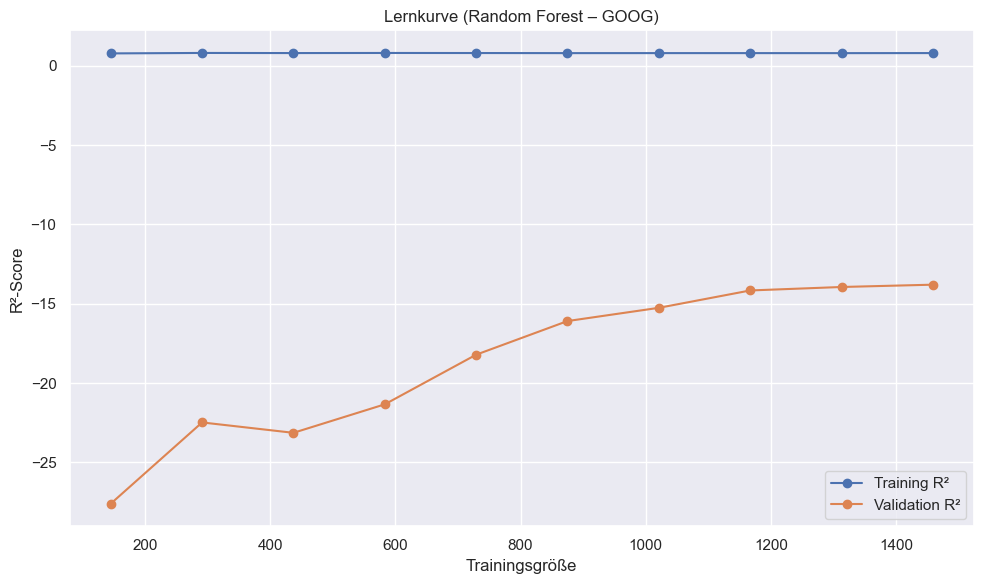

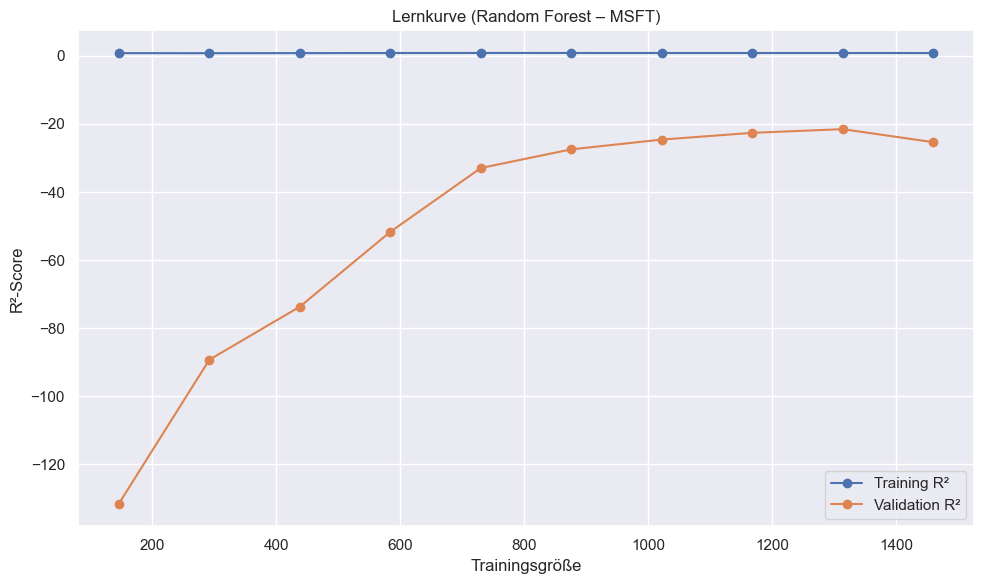

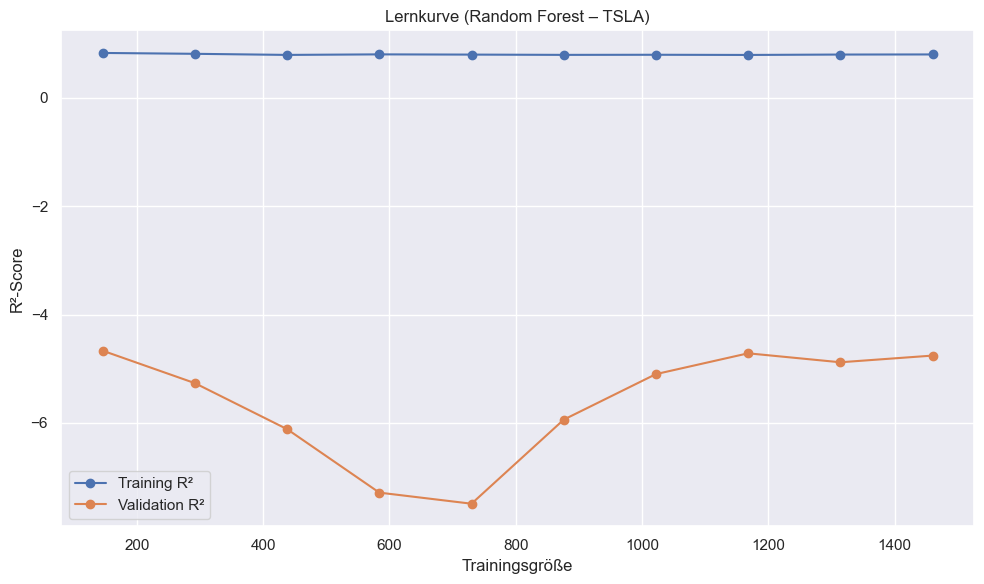

In [21]:
firmen = merged_data.keys()

for firma in firmen:
    df = merged_data[firma]
    X = df[['sentiment_score']]
    y = df['close_value']

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training R²')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation R²')
    plt.title(f'Lernkurve (Random Forest – {firma})')
    plt.xlabel("Trainingsgröße")
    plt.ylabel("R²-Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 11. Visuelle Analyse pro Unternehmen

- Für jedes Unternehmen mit ausreichend Daten wurde ein Regressionsplot erzeugt

- Ziel: Grafische Darstellung des Zusammenhangs zwischen Sentiment und Schlusskurs

- Vorteil: Vergleichbarkeit von Mustern zwischen verschiedenen Firmen (z. B. starker vs. schwacher Zusammenhang)

- Erkenntnis: Visuelle Hinweise auf lineare oder nicht-lineare Trends – ergänzt numerische Korrelation und Modellmetriken



In [ ]:
##Ergebnisse vergleichen: Sentiment und Kurswerte für verschiedene Unternehmen

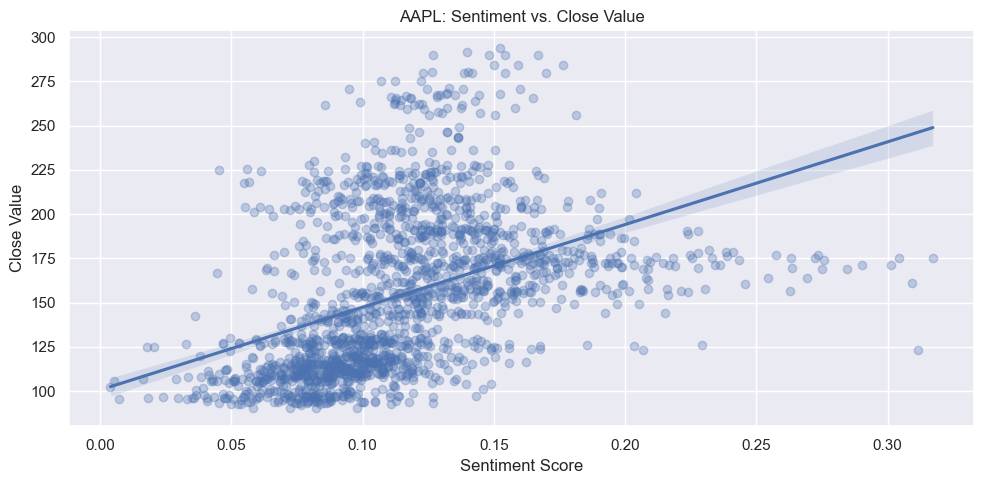

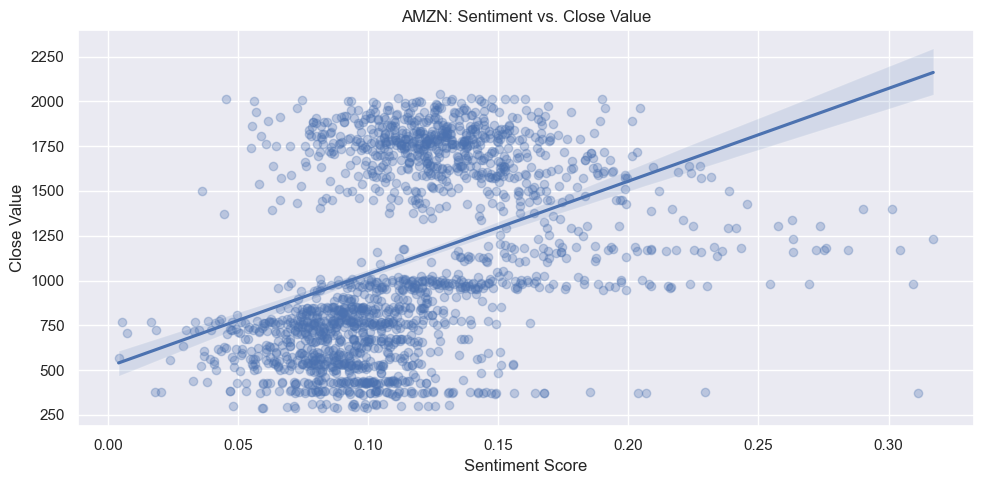

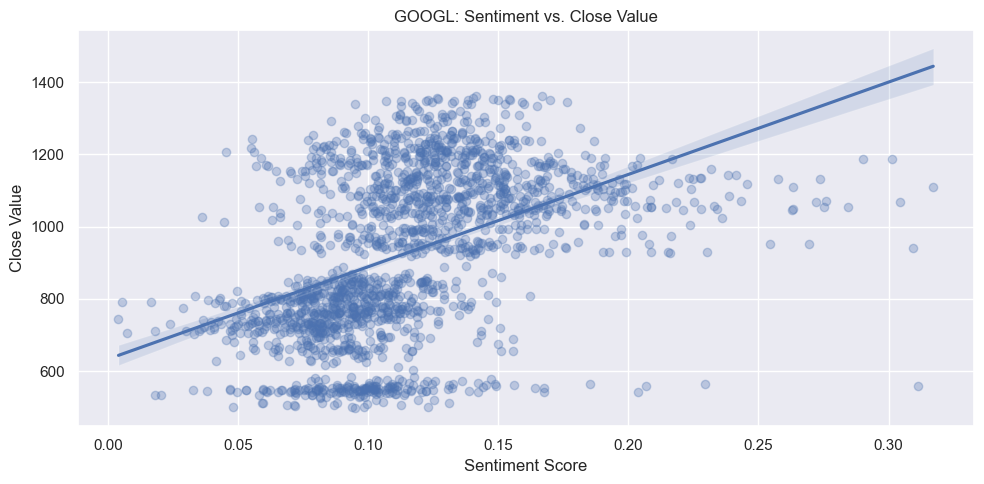

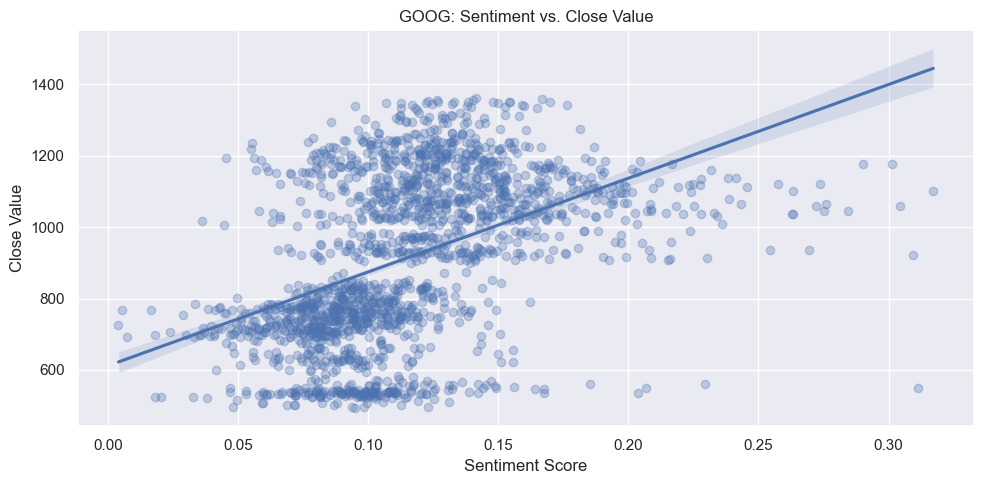

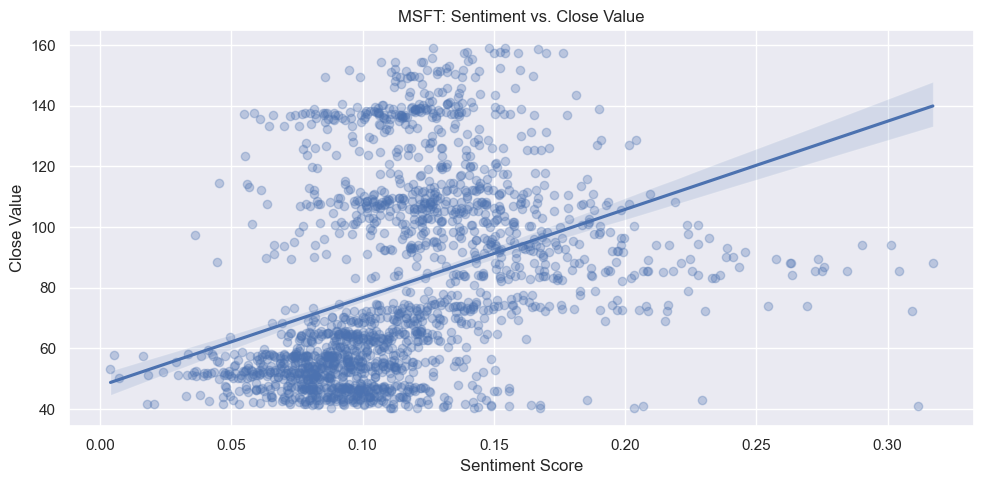

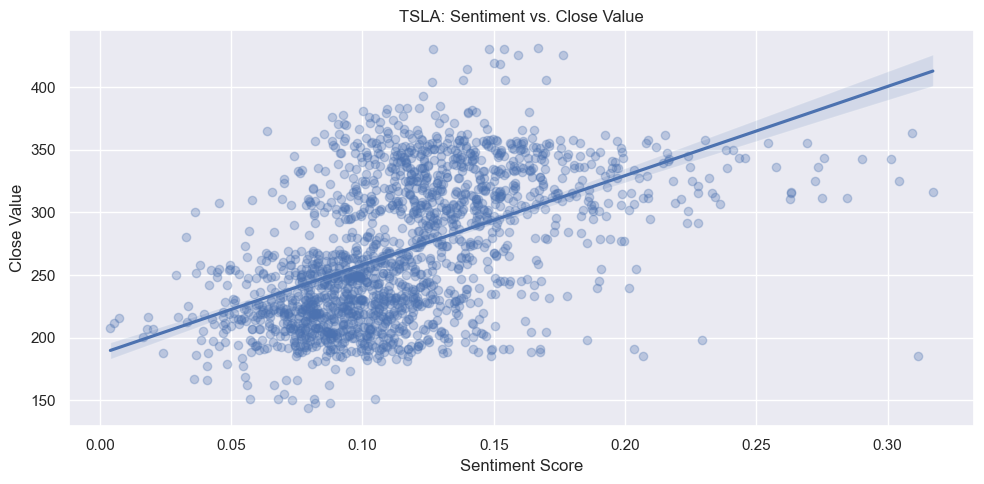

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste aller Firmen im Datensatz
firmen = merged_df['ticker_symbol'].unique()

# Für jede Firma den Zusammenhang darstellen
for firma in firmen:
    df_firma = merged_df[merged_df['ticker_symbol'] == firma]

    if df_firma.shape[0] < 30:
        continue  # zu wenige Daten, überspringen

    plt.figure(figsize=(10, 5))
    sns.regplot(data=df_firma, x='sentiment_score', y='close_value', scatter_kws={'alpha':0.3})
    plt.title(f"{firma}: Sentiment vs. Close Value")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 12. Sentimentverlauf im Zeitkontext mit Aktienkurs

- Visualisierung zeigt Sentiment-Scores (z. B. VADER oder AFINN) über die Zeit hinweg

- Kombiniert mit dem Verlauf des Schlusskurses der Aktie

- Ziel: Identifizieren möglicher Zusammenhänge zwischen Stimmungsschwankungen und Kursveränderungen

- Besonders geeignet für ereignisbasierte Analysen 




2. Liniendiagramm: Sentiment vs. Aktienkurs über Zeit

Visualisiert zeitlich: Wann starke positive oder negative Tweets auftraten und wie sich der Aktienkurs parallel dazu veränderte.



In [1]:
def sentiment_overtime(tweet_df, stock_df, title, score_column_name="score"):
    fig = plt.figure(figsize=(24,10))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()

    # Sentiment (Vader oder Afinn)
    ax1.vlines(tweet_df['day_date'], 0, tweet_df[score_column_name])
    ax1.axhline(y=0, color='r', linestyle='-')

    # Aktienkurs (Close)
    ax2.plot(stock_df['day_date'], stock_df['close_value'], color='orange', label='Stock price')

    ax2.set_title("Effects of " + title +" tweets to stock price")
    ax1.set_xlabel('Datum')
    ax1.set_ylabel('Sentiment Score', color="blue")
    plt.show()


### 13. Evaluation
- Unternehmensliste definiert: ['AAPL', 'AMZN', 'GOOGL', 'GOOG', 'MSFT', 'TSLA']

- Toleranzgrenze festgelegt: ±10 $

- Für jedes Unternehmen:

- Datensatz geladen (merged_data[unternehmen])

- Features (sentiment_score) und Ziel (close_value) extrahiert

- Daten in Trainings- und Testset aufgeteilt (test_size=0.99 = fast alles ist Testdaten)

- RandomForestRegressor trainiert mit 100 Bäumen

- Vorhersage auf Testdaten berechnet

- Abweichung berechnet (abs(y_test - y_pred))

- Anzahl der Vorhersagen innerhalb ±10 $ gezählt

- Trefferquote in % ermittelt

- R²-Score als Gütemaß der Regression ausgegeben

- Ergebnisse pro Unternehmen als Text ausgegeben

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

# Unternehmen
firmen = ['AAPL', 'AMZN', 'GOOGL', 'GOOG', 'MSFT', 'TSLA']

# Toleranzschwelle (z. B. ±10 $)
toleranz = 10

# Ergebnisse sammeln
for firma in firmen:
    print(f"\n {firma}")
    df = merged_data[firma]
    X = df[['sentiment_score']]
    y = df['close_value']

    # Aufteilen in Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

    # Modell trainieren
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Vorhersage
    y_pred = model.predict(X_test)

    # Auswertung: Wie viele Vorhersagen liegen innerhalb der Toleranz?
    fehler = np.abs(y_test - y_pred)
    korrekte = (fehler <= toleranz).sum()
    gesamt = len(y_test)
    anteil = korrekte / gesamt

    # R²-Score zur Referenz
    r2 = r2_score(y_test, y_pred)

    # Ergebnis ausgeben
    print(f"- Vorhersagen innerhalb ±{toleranz}$: {korrekte} von {gesamt}")
    print(f"- Trefferquote: {anteil:.2%}")
    print(f"- R²-Score: {r2:.4f}")



 AAPL
- Vorhersagen innerhalb ±10$: 481 von 1800
- Trefferquote: 26.72%
- R²-Score: 0.1492

 AMZN
- Vorhersagen innerhalb ±10$: 19 von 1807
- Trefferquote: 1.05%
- R²-Score: -0.3483

 GOOGL
- Vorhersagen innerhalb ±10$: 74 von 1807
- Trefferquote: 4.10%
- R²-Score: -0.2675

 GOOG
- Vorhersagen innerhalb ±10$: 57 von 1806
- Trefferquote: 3.16%
- R²-Score: -0.8077

 MSFT
- Vorhersagen innerhalb ±10$: 608 von 1807
- Trefferquote: 33.65%
- R²-Score: -0.1808

 TSLA
- Vorhersagen innerhalb ±10$: 210 von 1807
- Trefferquote: 11.62%
- R²-Score: -0.4788
